# NYC Rolling Sales Machine Learning Model

## EDA

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import pymssql
import time
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm

# import model libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import pickle

# Popular Regression Algorithms

lm = LinearRegression()
mlp = MLPRegressor(random_state = 42)
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 42)
xgbt = xgb.XGBRegressor(random_state = 42)
dtree = DecisionTreeRegressor(random_state = 42)

d:\anaconda3\envs\machine-learning\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
d:\anaconda3\envs\machine-learning\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read in Rolling Sales data from sql database
database = "group-6-finance"
user = "ericks"
password  = "MYP4SSW0RD!"
server = "gen10-data-fundamentals-22-07-sql-server.database.windows.net"

cnxn = pymssql.connect(server, user, password, database)
cursor = cnxn.cursor()

query = f'SELECT * FROM RawRollingSales'
data = pd.read_sql(query, cnxn)

d:\anaconda3\envs\machine-learning\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
data.corr().abs().unstack().sort_values(ascending = False)["SALE PRICE"]

In [ ]:
data.info()

In [ ]:
data.head()

In [ ]:
data.hist(figsize=(15,10))

In [ ]:
round(data.describe(), 3)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))

mask = np.triu(np.ones_like(data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

d:\anaconda3\envs\xgboost\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


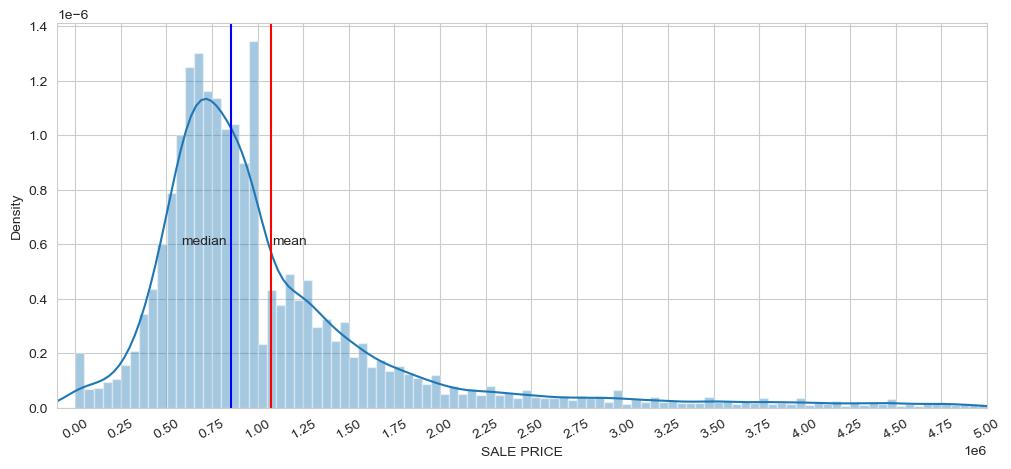

In [3]:
# dist plot of sales price
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.distplot(data[(data['SALE PRICE']>100) & (data['SALE PRICE'] < 5000000)]['SALE PRICE'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000, 5000000])
plt.xticks(rotation=30)
plt.axvline(data[(data['SALE PRICE']>100) & (data['SALE PRICE'] < 5000000)]['SALE PRICE'].mean(), c='red')
plt.axvline(data[(data['SALE PRICE']>100) & (data['SALE PRICE'] < 5000000)]['SALE PRICE'].median(), c='blue')
plt.text(580000,0.0000006, "median")
plt.text(1080000,0.0000006, "mean")
plt.show()

In [ ]:
# # create dist plot with plotly
# import plotly.figure_factory as ff

# hist_data = [[x for x in data["SALE PRICE"] if x > 100 and x < 5000000]]
# group_labels = ["Sale Price"]

# fig = ff.create_distplot(hist_data, group_labels)

In [ ]:
#Check each column for outliers

# for column in data.columns:
#     if(pd.api.types.is_numeric_dtype(data[column])):
#         mean = data[column].mean()
#         std = data[column].std()
#         new_df = data[(data[column] < (mean - 3 * std)) | (data[column] > (mean + 3 * std))] 
#         print(f'=======================================================')
#         print(f'Column: {column}') 
#         print(f'mean: {mean}, std:{std}')
#         print(f'Lower Bound: {mean - 3 * std}, Upper Bound: {mean + 3 * std}')
#         print(f'Outlier count: {data.shape[0]} ')
#         plt.boxplot(data[column])
#         plt.show()
#         print(f'=======================================================')

In [ ]:
# # check for dulicate rows
# data.duplicated().sum()

In [ ]:
# find all zero's in columns
# for col in data.columns:
#     print(f"column {col}: {len(data[data[col] == 0])}")

In [ ]:
# # print out number of unique values in columns
# for col in data.columns:
#     print(f"column {col}: {data[col].nunique()}")

### Initial cleanup based on EDA

In [ ]:
#data[["BUILDING CLASS CATEGORY", "BUILDING CLASS AT TIME OF SALE"]].value_counts()

In [ ]:
# separate data based on building class category into residential and commercial
#data["BUILDING CLASS CATEGORY"].unique()


In [3]:
# change data types of columns to split between categorical and numeric data
data["BOROUGH"] = data["BOROUGH"].astype(str)
data["BLOCK"] = data["BLOCK"].astype(str)
data["LOT"] = data["LOT"].astype(str)
data["ZIP CODE"] = data["ZIP CODE"].astype(int).astype(str)
data["TAX CLASS AT TIME OF SALE"] = data["TAX CLASS AT TIME OF SALE"].astype(str)
data["YEAR BUILT"] = data["YEAR BUILT"].astype(int)
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"])

In [8]:
# Removing data where commercial + residential doesn't equal total units

print(f"Length data before: {len(data)}")
data = data[data['TOTAL UNITS'] == data['COMMERCIAL UNITS'] + data['RESIDENTIAL UNITS']]
print(f"Length data after: {len(data)}")

Length data before: 31241
Length data after: 31241


In [ ]:
# check counts of total units values
# data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

In [ ]:
# look at high unit counts with histogram
# data[data["TOTAL UNITS"] >200]["TOTAL UNITS"].hist()

### Remove outliers

In [ ]:
data.corr().abs().unstack().sort_values(ascending = False)["SALE PRICE"]

In [ ]:
round(data.describe(), 3)

In [4]:
# remove outliers for each column if value is greater than 3 standard deviations from the mean
# change each outlier to np.nan
for column in data.columns:
    if (pd.api.types.is_numeric_dtype(data[column])):
        mean = data[column].mean()
        std = data[column].std()
        data[column] = data[column].apply(lambda x: np.nan if (x < (mean - 2 * std)) | (x > (mean + 2 * std)) else x)
# create new df with outlier rows cleaned
data.dropna(inplace=True)

In [ ]:
data.corr().abs().unstack().sort_values(ascending = False)["SALE PRICE"]

## Feature Engineering

### Clean up columns for model

In [5]:
# create age column
data["SALE YEAR"] = data["SALE DATE"].apply(lambda x: x.year)
data["AGE"] = data["SALE YEAR"] - data["YEAR BUILT"]

In [ ]:
# # find all zero's in columns
# for col in sales.columns:
#     print(f"column {col}: {len(sales[sales[col] == 0])}")

## Test model(s)

### Test multiple algorithms and check results

In [ ]:
# drop columns that are not numeric or categorical
# sales = data.drop(["LOT", "ADDRESS", "YEAR BUILT", "SALE DATE", "SALE YEAR", "BOROUGH", "BLOCK", "BUILDING CLASS CATEGORY"], axis=1)

# drop columns that are not numeric or categorical
sales = data.drop(["LOT", "ADDRESS", "YEAR BUILT", "SALE DATE", "SALE YEAR", "BOROUGH", "BLOCK", "BUILDING CLASS CATEGORY"], axis=1)

# split test and train
y = sales.pop("SALE PRICE")
X = sales.copy()
# create dummies in X
X_with_dummies = pd.get_dummies(X,drop_first=True)
# create test/train split
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, random_state=0, test_size=0.25)

# run baseline models on cleaned data
algo = [xgbt,rf,lm,ridge,lasso,knn,dtree,mlp]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
round(result_raw_model, 3)

### Model optimization

In [2]:
# # eliminate features with greater than 75% correlation with each other
# mtr = sales.corr()
# mask = np.zeros_like(mtr)
# mask[np.triu_indices_from(mask)] = True
# fig, ax = plt.subplots(figsize=(16,12))
# plt.suptitle("Correlation Matrix of Columns in Heatmap", size=24)
# sns.heatmap(mtr, mask= mask, annot=True, annot_kws={"size": 10});

In [ ]:
# create optimized model 
sales_opt = data.copy()
# check length of dataframe with residential categories only

# drop TOTAL UNITS as correlation is >75% with residential units
# drop YEAR BUILT, AGE and SALE YEAR as they have low correlation to SALES PRICE
# for categorical variable, keep ZIP CODE, NEIGHBORHOOD, and BUILDING CLASS CATEGORY AT TIME OF SALE, TAX CLASS AT TIME OF SALE
sales_opt.drop(["LOT", "ADDRESS", "YEAR BUILT", "SALE DATE", "SALE YEAR", "BOROUGH", "BLOCK",
                      "TOTAL UNITS", "BUILDING CLASS CATEGORY",
                      "AGE"], axis=1, inplace=True)

# split test and train
y = sales_opt.pop("SALE PRICE")
X = sales_opt.copy()
# create dummies in X
X_with_dummies = pd.get_dummies(X,drop_first=True)
# create test/train split
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, random_state=0, test_size=0.25)

# run baseline models on cleaned & optimized data
# took out these algos from loop as they aren't performing as well: lm,ridge,lasso,knn,dtree,mlp
algo = [xgbt,rf]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
round(result_raw_model, 3)

In [6]:
# create model with residential building class category only

# filter out non-residential building class categories
sales_res = data[data["BUILDING CLASS CATEGORY"].isin(['01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS',
       '03 THREE FAMILY DWELLINGS', '07 RENTALS - WALKUP APARTMENTS',
       '08 RENTALS - ELEVATOR APARTMENTS',
       '14 RENTALS - 4-10 UNIT'])]

# drop TOTAL UNITS as correlation is >75% with residential units
# drop YEAR BUILT, AGE and SALE YEAR as they have low correlation to SALES PRICE
# for categorical variable, keep ZIP CODE, NEIGHBORHOOD, and BUILDING CLASS CATEGORY AT TIME OF SALE, TAX CLASS AT TIME OF SALE
sales_res.drop(["LOT", "ADDRESS", "YEAR BUILT", "SALE DATE", "SALE YEAR", "BOROUGH", "BLOCK",
                      "TOTAL UNITS", "BUILDING CLASS CATEGORY",
                      "AGE"], axis=1, inplace=True)

# split test and train
y = sales_res.pop("SALE PRICE")
X = sales_res.copy()
# create dummies in X
X_with_dummies = pd.get_dummies(X,drop_first=True)
# create test/train split
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, random_state=0, test_size=0.25)

# run models on residential data
# took out these algos from loop as they aren't performing as well: lm,ridge,lasso,knn,dtree,mlp
algo = [xgbt,rf]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
round(result_raw_model, 3)

C:\Users\newal\AppData\Local\Temp\ipykernel_3964\4177133522.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_res.drop(["LOT", "ADDRESS", "YEAR BUILT", "SALE DATE", "SALE YEAR", "BOROUGH", "BLOCK",
d:\anaconda3\envs\machine-learning\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor ✓     55.671875 sn
RandomForestRegressor ✓     160.53125 sn


,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor_baseline,0.947,0.699,481614.450,1177315.806,161731.727,407722.402
XGBRegressor_baseline,0.930,0.690,551985.059,1194167.554,293324.058,433177.238


### Optimize Random Forest with grid search

In [7]:
# choose random forest as model and use grid search to optimize parameters
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf = RandomForestRegressor(random_state = 42)

rf_tuned = GridSearchCV(estimator = rf,
                            param_grid = param_grid,
                            cv = 2,
                            n_jobs=-1,
                        verbose=0)

rf_tuned.fit(X_train, y_train)
rf_tuned.best_estimator_

RandomForestRegressor(max_depth=100, max_features=14, n_estimators=300,
                      random_state=42)

In [8]:
# results for grid search optimized random forest model
best_rf_model = rf_tuned.best_estimator_.fit(X_train,y_train)
result_optimize_model = []
result_optimize_model.append(["RandomForestRegressor Optimize", model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])

result = pd.DataFrame(result_optimize_model, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
round(result, 3)

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor Optimize,0.947,0.699,481614.45,1177315.806,161731.727,407722.402


### Model visualizations - Random Forest

In [9]:
# feature importance chart for random forest
rankings = best_rf_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["Feature","Importance"]).sort_values("Importance",ascending = False)

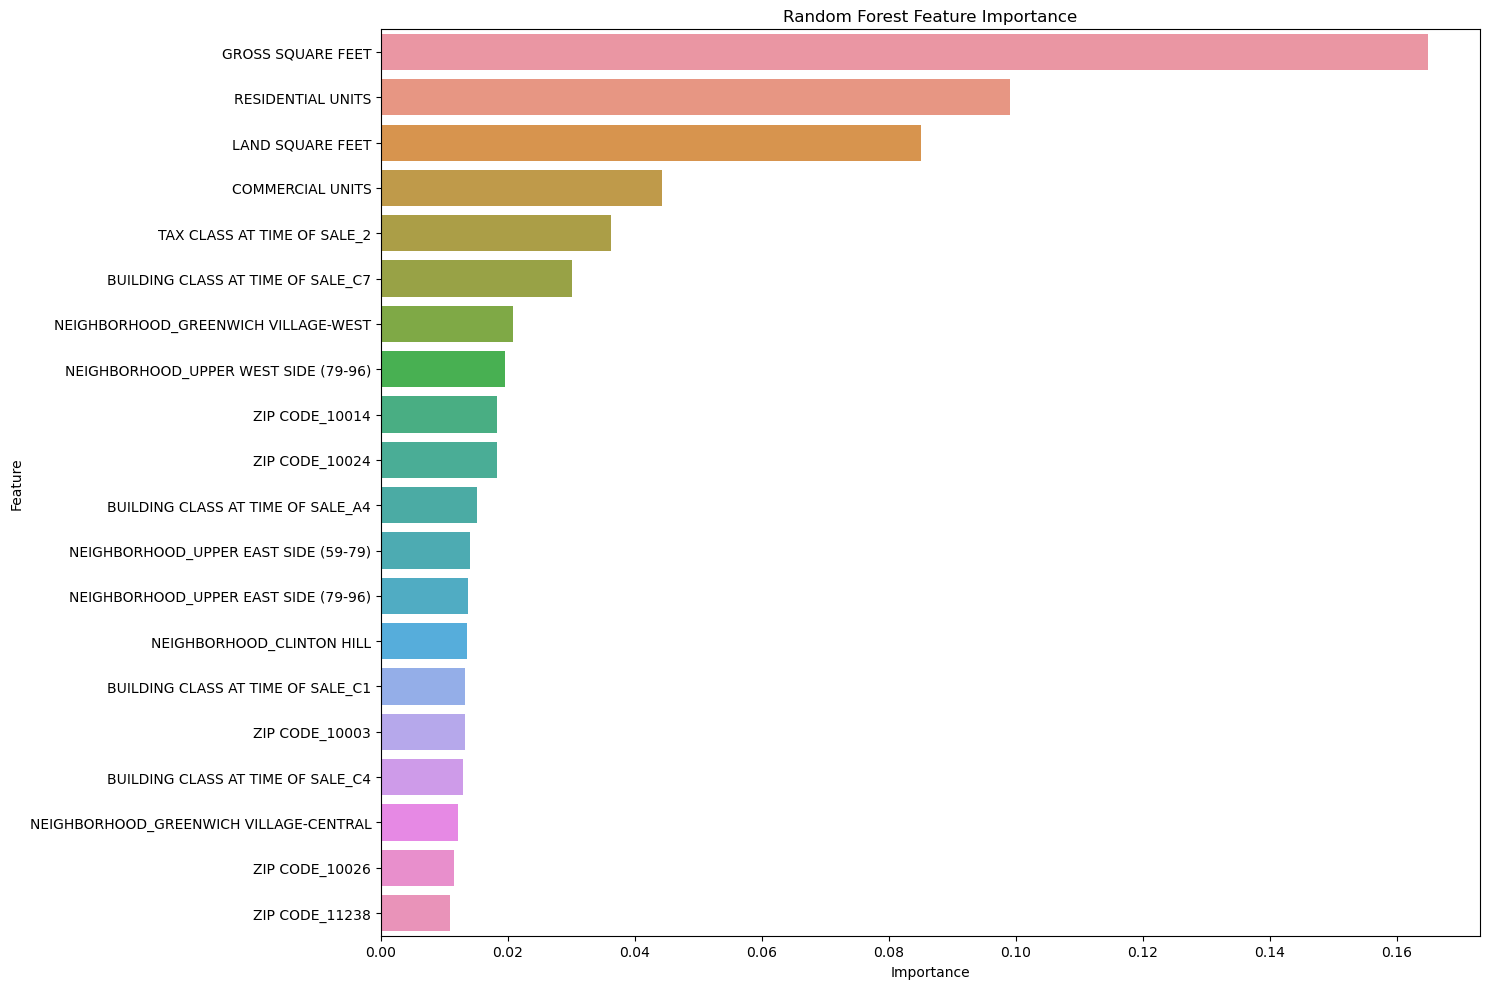

In [10]:
plt.figure(figsize=(15,10))
sns.barplot(x="Importance",
            y="Feature",
            data=importance[0:20])
plt.title('Random Forest Feature Importance')
plt.tight_layout()

In [39]:
# random forest feature importance in plotly express
random_forest_feature_fig = px.bar(importance[0:20].sort_values("Importance"), x='Importance', y='Feature',
            color='Importance', orientation='h', color_continuous_scale=px.colors.sequential.Magenta,
            height=800, title='Random Forest Feature Importance')
random_forest_feature_fig.update_layout(coloraxis_showscale=False)
random_forest_feature_fig.show()

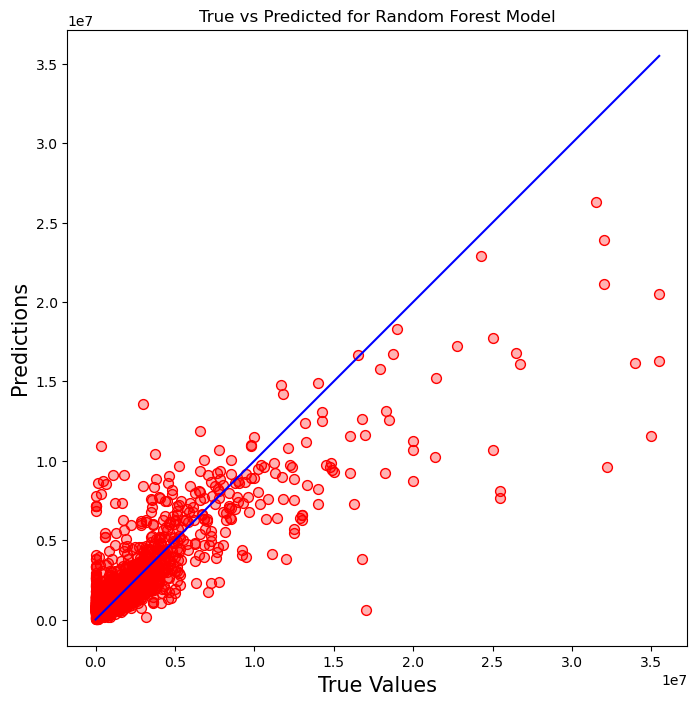

In [12]:
# true vs predicted values for random forest

# rf.fit(X_train,y_train)
predictions_rf = best_rf_model.predict(X_test)

plt.figure(figsize=(8,8))
plt.scatter(y_test, predictions_rf, s=50, marker='o', edgecolor='r', facecolor=(1,0,0,0.3))

p1 = max(max(predictions_rf), max(y_test))
p2 = min(min(predictions_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('True vs Predicted for Random Forest Model')
plt.show()

In [23]:
# true vs predicted values for random forest in Plotly
fig_rf = px.scatter(
    x=y_test, y=predictions_rf,
    trendline='ols', trendline_color_override='royalblue',
    color_discrete_sequence=['crimson'],
    title="Actual vs. Predicted Sale Price for Random Forest Model",
    width=600, height=600
)
fig_rf.update_traces(marker=dict(
            color='rgba(220, 20, 60, 0.3)',
            size=6,
            line=dict(
                color='rgb(220, 20, 60)',
                width=1
            )
    )
)
fig_rf.update_layout(
    xaxis_title="Actual Value",
    yaxis_title="Predicted Value",
    legend_title="Legend Title"
)
# fig_rf.update_layout({
#     'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#     'paper_bgcolor': 'rgba(0, 0, 0, 0)'}
# )
fig_rf.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_rf.update_yaxes(showline=True, linewidth=2, linecolor='black',
                    showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_rf.add_shape(type='line',
                x0=0,
                y0=0,
                x1=max(y_test),
                y1=max(y_test),
                line=dict(color='royalblue'),
                xref='x',
                yref='y'
)
fig_rf.show()

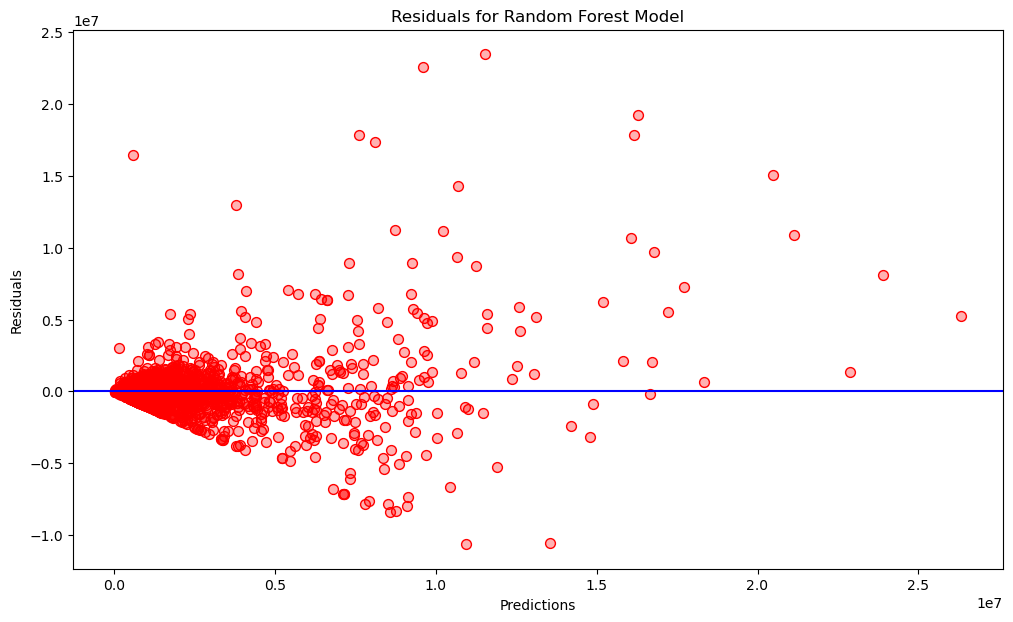

In [25]:
# random forest residuals plot
residuals_rf = (y_test - predictions_rf)

plt.figure(figsize=(12,7))
plt.scatter(predictions_rf, residuals_rf, s=50, marker='o', edgecolor='r', facecolor=(1,0,0,0.3))
#plt.plot([min(predictions_rf), max(predictions_rf)],[min(residuals), max(residuals)],  color='r')

#ax.vlines(residuals,predictions_rf,y+dy)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Residuals for Random Forest Model")
plt.axhline(y=0, color='b')
plt.show()

In [27]:
# random forest residuals plot in plotly

fig_rf_res = px.scatter(
    x=predictions_rf, y=residuals_rf,
    color_discrete_sequence=['crimson'],
    title="Residuals for Random Forest Model",
    width=800, height=600
)
fig_rf_res.update_traces(marker=dict(
            color='rgba(220, 20, 60, 0.3)',
            size=6,
            line=dict(
                color='rgb(220, 20, 60)',
                width=1
            )
      )
)
fig_rf_res.update_layout(
    xaxis_title="Predicted Value",
    yaxis_title="Residuals",
    legend_title="Residuals Plot for XGBoost"
)
fig_rf_res.add_shape(type='line',
                x0=-1e6,
                y0=0,
                x1=31.5e6,
                y1=0,
                line=dict(color='royalblue'),
                xref='x',
                yref='y'
)
# fig_rf_res.update_layout({
#     'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#     'paper_bgcolor': 'rgba(0, 0, 0, 0)'}
# )
fig_rf_res.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_rf_res.update_yaxes(showline=True, linewidth=2, linecolor='black',
                     showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_rf_res.show()

### Model visualizations - XGBoost

In [28]:
# xgb feature importance
xgb_reg = xgb.XGBRegressor().fit(X_train, y_train)
xgb_feat_imp = xgb_reg.get_booster().get_score(importance_type='gain')
xgb_imp_df = pd.DataFrame.from_dict(data=xgb_feat_imp, orient='index')
xgb_feat = xgb_imp_df.reset_index().rename(columns={"index": "Feature", 0: "Importance"}).sort_values("Importance", ascending=False)
xgb_feat.head()

d:\anaconda3\envs\machine-learning\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



,Feature,Importance
25,NEIGHBORHOOD_CLINTON HILL,6.954102e+14
102,NEIGHBORHOOD_UPPER WEST SIDE (79-96),3.648302e+14
12,NEIGHBORHOOD_BEDFORD STUYVESANT,3.447936e+14
121,ZIP CODE_10014,3.199190e+14
71,NEIGHBORHOOD_MORRISANIA/LONGWOOD,2.530756e+14


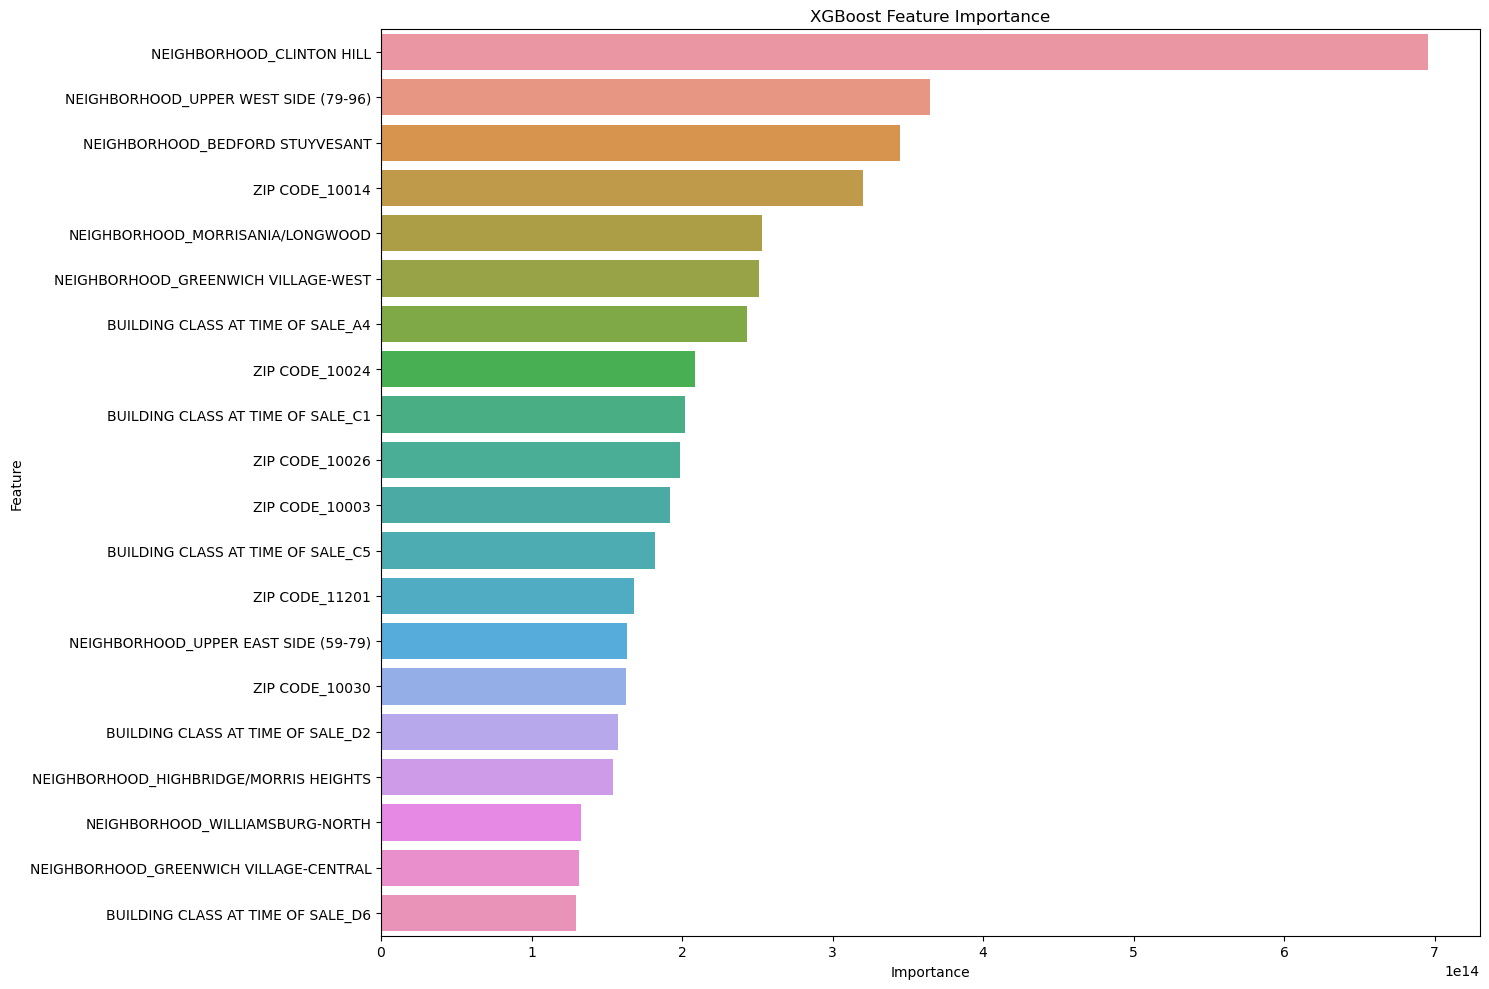

In [29]:
# plot top 20 feature importance for xgBoost
plt.figure(figsize=(15,10))
sns.barplot(x="Importance",
            y="Feature",
            data=xgb_feat[0:20])
plt.title('XGBoost Feature Importance')
plt.tight_layout()

In [37]:
# xgboost feature importance in plotly express

xgboost_features_fig = px.bar(xgb_feat[0:20].sort_values("Importance"), x='Importance', y='Feature',
            color='Importance', orientation='h', color_continuous_scale=px.colors.sequential.Magenta,
            height=800, title='XGBoost Feature Importance')
xgboost_features_fig.update_layout(coloraxis_showscale=False)
xgboost_features_fig.show()

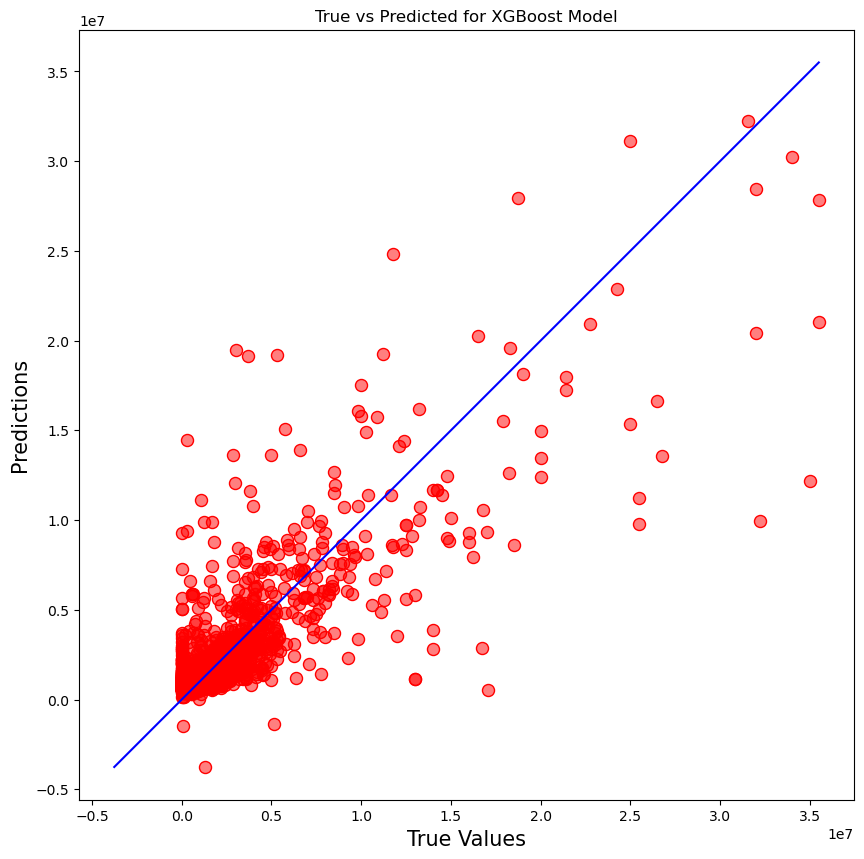

In [30]:
# XGBoost predictions vs actual
#xgbt.fit(X_train,y_train)
predictions = xgb_reg.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, s=75, marker='o', edgecolor='r', facecolor=(1,0,0,0.5))

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('True vs Predicted for XGBoost Model')
plt.show()

In [32]:
# XGBoost predictions vs actual with Plotly
fig_xgb = px.scatter(
    x=y_test, y=predictions,
    color_discrete_sequence=['crimson'],
    title="Actual vs. Predicted Sale Price for XGBoost Model",
    height=600, width=600
)
fig_xgb.update_traces(marker=dict(
            color='rgba(220, 20, 60, 0.3)',
            size=6,
            line=dict(
                color='rgb(220, 20, 60)',
                width=1
            )
      )
)
fig_xgb.update_layout(
    xaxis_title="Actual Value",
    yaxis_title="Predicted Value",
    legend_title="Legend Title"
)
fig_xgb.add_shape(type='line',
                x0=min(min(y_test), min(predictions)),
                y0=min(min(y_test), min(predictions)),
                x1=max(max(y_test), max(predictions)),
                y1=max(max(y_test), max(predictions)),
                line=dict(color='royalblue'),
                xref='x',
                yref='y'
)
# fig_xgb.update_layout({
#     'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#     'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig_xgb.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1)
fig_xgb.update_yaxes(showline=True, linewidth=2, linecolor='black',
                     showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1)
fig_xgb.show()

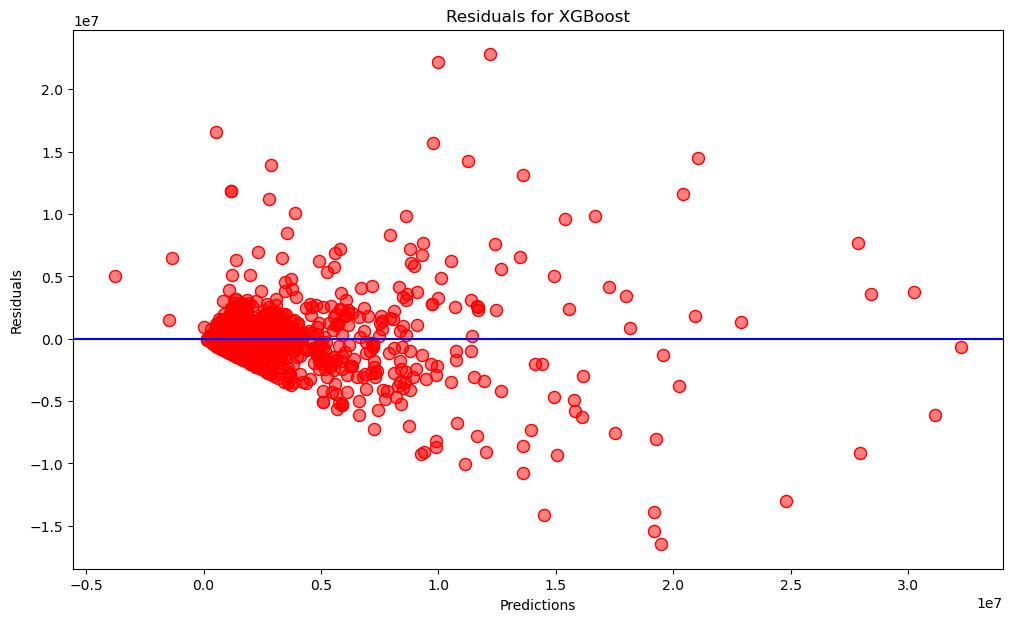

In [34]:
# plot residuals for xgboost
residuals = (y_test - predictions)
plt.figure(figsize=(12,7))
plt.scatter(predictions, residuals, s=75, marker='o', edgecolor='r', facecolor=(1,0,0,0.5))

#plt.plot([min(predictions), max(predictions)],[min(residuals), max(residuals)],  color='r')

#ax.vlines(residuals,predictions,y+dy)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Residuals for XGBoost")
plt.axhline(y=0, color='b')
plt.show()

In [36]:
# plot residuals for xgboost with Plotly

fig_xgb_res = px.scatter(
    x=predictions, y=residuals,
    color_discrete_sequence=['crimson'],
    title="Residuals for XGBoost Model",
    width=800, height=600
)
fig_xgb_res.update_traces(marker=dict(
            color='rgba(220, 20, 60, 0.3)',
            size=6,
            line=dict(
                color='rgb(220, 20, 60)',
                width=1
            )
      )
)
fig_xgb_res.update_layout(
    xaxis_title="Predicted Value",
    yaxis_title="Residuals",
    legend_title="Residuals Plot for XGBoost"
)
fig_xgb_res.add_shape(type='line',
                x0=0,
                y0=0,
                x1=27e6,
                y1=0,
                line=dict(color='royalblue'),
                xref='x',
                yref='y'
)
# fig_xgb_res.update_layout({
#     'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#     'paper_bgcolor': 'rgba(0, 0, 0, 0)'}
# )
fig_xgb_res.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_xgb_res.update_yaxes(showline=True, linewidth=2, linecolor='black',
                     showgrid=True, gridcolor='lightgray', zeroline=True,
                    zerolinecolor='lightgray', zerolinewidth=1
)
fig_xgb_res.show()

# Results

Introduction

We made our model using property sales data from the past year (September 2021 - August 2022) in New York City. The data has numeric and categorical features describing a property's physical characteristics, location, property classifications and price. Our model predicts the price of a home based on these features.

Data Cleaning

We dropped rows with na values in the total units and gross square feet columns, as these features were highly correlated with our target variable, and this improved the model's accuracy. Outliers were removed from numeric columns with greater than two standard deviations from the mean.

Feature Engineering

Features with low correlation (<30%) were removed. Feature with correlation greater than 75% with other features were removed. Zipcode, neighborhood, building class at sale and tax class at sale were included as categorical features. Residential units, commercial units, gross square feet and land square feet were included as numeric features. Building class category was filtered for residential categories for best results.

Outcomes

The two best performing baseline models were random forest regression and XGBoost regression. The random forest model was tuned with grid search, giving optimal parameters of (max_depth=100, max_features=14, n_estimators=300, random_state=42). This was the best performing model with a test score of 0.699. The most important features of this model were gross square feet, residential units, land square feet and commercial units. This contrasted significantly with the feature importance for the XGBoost model, where the most important features were categorical, including zip code and neighborhood. Random forest had a slightly higher score and lower errors than XGBoost. The predictions versus actuals plots revealed that random forest tended to underprice properties with high actual prices, while XGBoost did not have this tendency.